# Model Manager for Open Source models

# PREPARATION: DATA IMPORT AND PACKAGE INSTALLATION

In [1]:
#Import generic packages
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import requests
import os, json
import pprint
import getpass

C:\Users\canyzn\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import sklearn

In [3]:
sklearn.__version__

'0.24.1'

In [4]:
# Data Mining and Machine Learning packages
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.base import TransformerMixin
import sklearn.metrics as metrics
import sklearn.model_selection as model_selection
import statsmodels.api as smodel
from xgboost import XGBClassifier 

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

C:\Users\canyzn\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [5]:
# Model Management packages
#Import dependencies for pzmm package
import requests
#!pip install pysftp
import pysftp
import swat

In [6]:
# Define file directory
dm_nodedir = 'C:/Users/canyzn/Desktop/HMEQ/OpenMM'

In [7]:
dataFolder = Path.cwd()/'Data'
zipFolder_RF = Path.cwd()/'Model'/'Random_Forest'
zipFolder_XGB= Path.cwd()/'Model'/'XGBoost'

In [8]:
#-------------------------------------------------------------------------------
# Import data
#-------------------------------------------------------------------------------
import pandas as pd
df = pd.read_csv('C:/Users/canyzn/Desktop/HMEQ/hmeq.csv',sep=',')

# DATA ENGINEERING

In [9]:
#Drop duplicates
df.drop_duplicates(inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 651.9+ KB


In [11]:
# Modify data type
cols = df[df.columns.difference(['BAD','LOAN','REASON','JOB'])].columns
df[cols] = df[cols].apply(pd.to_numeric, downcast='float', errors='coerce')
df['BAD']=df['BAD'].astype('category')

In [12]:
# Declare variables
#target var
target = df.select_dtypes('category').columns

#categorical (nominal and ordinal) variables
class_inputs = list(df.select_dtypes('object').columns)

#input interval variables
numerical_inputs = list(df.select_dtypes(include=['int64', 'float32']).columns)

inputs= class_inputs + numerical_inputs

print(target)
print(class_inputs)
print(numerical_inputs)
print(inputs)

Index(['BAD'], dtype='object')
['REASON', 'JOB']
['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']
['REASON', 'JOB', 'LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   BAD      5960 non-null   category
 1   LOAN     5960 non-null   int64   
 2   MORTDUE  5442 non-null   float32 
 3   VALUE    5848 non-null   float32 
 4   REASON   5708 non-null   object  
 5   JOB      5681 non-null   object  
 6   YOJ      5445 non-null   float32 
 7   DEROG    5252 non-null   float32 
 8   DELINQ   5380 non-null   float32 
 9   CLAGE    5652 non-null   float32 
 10  NINQ     5450 non-null   float32 
 11  CLNO     5738 non-null   float32 
 12  DEBTINC  4693 non-null   float32 
dtypes: category(1), float32(9), int64(1), object(2)
memory usage: 401.7+ KB


In [14]:
##Finding the the count and percentage of values that are missing in the dataframe.
df_null = pd.DataFrame({'Count': df.isnull().sum(), 'Percent': 100*df.isnull().sum()/len(df)})

##printing columns with null count more than 0
df_null[df_null['Count'] > 0]  #Debtinc has the highest level of missing values: 21.3%

,Count,Percent
MORTDUE,518,8.691275
VALUE,112,1.879195
REASON,252,4.228188
JOB,279,4.681208
YOJ,515,8.640940
DEROG,708,11.879195
DELINQ,580,9.731544
CLAGE,308,5.167785
NINQ,510,8.557047
CLNO,222,3.724832


In [15]:
#Impute Missing values
categorical_imputer = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
numerical_imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')

# Impute categorical variables

categorical_imputer.fit(df[class_inputs])
categorical_imputed = categorical_imputer.transform(df[class_inputs])
df_categorical_imputed = pd.DataFrame(data=categorical_imputed, columns=class_inputs)
df_categorical_imputed.info()

print('-'*50)

#Impute numerical variables

numerical_imputer.fit(df[numerical_inputs])
numerical_imputed = numerical_imputer.transform(df[numerical_inputs])
df_numerical_imputed = pd.DataFrame(data=numerical_imputed, columns=numerical_inputs)
df_numerical_imputed.info()
df_numerical_imputed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   REASON  5960 non-null   object
 1   JOB     5960 non-null   object
dtypes: object(2)
memory usage: 93.2+ KB
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   LOAN     5960 non-null   float64
 1   MORTDUE  5960 non-null   float64
 2   VALUE    5960 non-null   float64
 3   YOJ      5960 non-null   float64
 4   DEROG    5960 non-null   float64
 5   DELINQ   5960 non-null   float64
 6   CLAGE    5960 non-null   float64
 7   NINQ     5960 non-null   float64
 8   CLNO     5960 non-null   float64
 9   DEBTINC  5960 non-null   float64
dtypes: float64(10)
memory usage: 465.8 KB


,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1100.0,25860.000000,39025.000000,10.500000,0.00000,0.000000,94.366669,1.000000,9.000000,33.779915
1,1300.0,70053.000000,68400.000000,7.000000,0.00000,2.000000,121.833336,0.000000,14.000000,33.779915
2,1500.0,13500.000000,16700.000000,4.000000,0.00000,0.000000,149.466660,1.000000,10.000000,33.779915
3,1500.0,73760.817199,101776.048741,8.922268,0.25457,0.449442,179.766275,1.186055,21.296096,33.779915
4,1700.0,97800.000000,112000.000000,3.000000,0.00000,0.000000,93.333336,0.000000,14.000000,33.779915
...,...,...,...,...,...,...,...,...,...,...
5955,78700.0,22762.000000,102997.000000,25.000000,0.00000,0.000000,146.632843,0.000000,13.000000,34.300201
5956,79100.0,23553.000000,103807.000000,25.000000,0.00000,1.000000,142.193451,0.000000,13.000000,31.469938
5957,79200.0,21694.000000,103143.000000,26.000000,0.00000,1.000000,139.938995,0.000000,14.000000,31.333685
5958,79200.0,22940.000000,110114.000000,28.000000,0.00000,1.000000,144.616119,0.000000,13.000000,32.366512


In [16]:
# One hot encoding for categorical variables
encoder = OneHotEncoder()
encoder.fit(categorical_imputed)
categorical_encoded = encoder.transform(categorical_imputed)

categories = list(np.hstack(encoder.categories_, ))
categories

# print(categorical_encoded.toarray())
df_categorical_encoded = pd.DataFrame(data=categorical_encoded.toarray(), columns=categories)
df_categorical_encoded.info()
df_categorical_encoded

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DebtCon  5960 non-null   float64
 1   HomeImp  5960 non-null   float64
 2   Mgr      5960 non-null   float64
 3   Office   5960 non-null   float64
 4   Other    5960 non-null   float64
 5   ProfExe  5960 non-null   float64
 6   Sales    5960 non-null   float64
 7   Self     5960 non-null   float64
dtypes: float64(8)
memory usage: 372.6 KB


,DebtCon,HomeImp,Mgr,Office,Other,ProfExe,Sales,Self
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
5955,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
5956,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
5957,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
5958,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [17]:
#Concanate all engineered features
abt = pd.concat([df[target], df_numerical_imputed, df_categorical_encoded], axis=1)
abt

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,DebtCon,HomeImp,Mgr,Office,Other,ProfExe,Sales,Self
0,1,1100.0,25860.000000,39025.000000,10.500000,0.00000,0.000000,94.366669,1.000000,9.000000,33.779915,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,1300.0,70053.000000,68400.000000,7.000000,0.00000,2.000000,121.833336,0.000000,14.000000,33.779915,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1,1500.0,13500.000000,16700.000000,4.000000,0.00000,0.000000,149.466660,1.000000,10.000000,33.779915,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1,1500.0,73760.817199,101776.048741,8.922268,0.25457,0.449442,179.766275,1.186055,21.296096,33.779915,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0,1700.0,97800.000000,112000.000000,3.000000,0.00000,0.000000,93.333336,0.000000,14.000000,33.779915,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,78700.0,22762.000000,102997.000000,25.000000,0.00000,0.000000,146.632843,0.000000,13.000000,34.300201,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
5956,0,79100.0,23553.000000,103807.000000,25.000000,0.00000,1.000000,142.193451,0.000000,13.000000,31.469938,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
5957,0,79200.0,21694.000000,103143.000000,26.000000,0.00000,1.000000,139.938995,0.000000,14.000000,31.333685,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
5958,0,79200.0,22940.000000,110114.000000,28.000000,0.00000,1.000000,144.616119,0.000000,13.000000,32.366512,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [18]:
abt[target].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5960 entries, 0 to 5959
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   BAD     5960 non-null   category
dtypes: category(1)
memory usage: 52.5 KB


# EDA

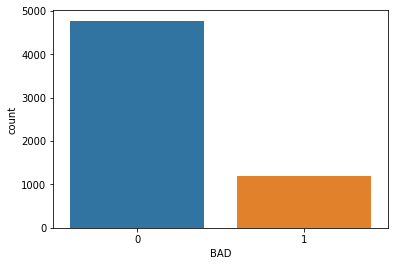

In [19]:
# Target distribution
sns.countplot(x="BAD", data=abt) #20% event =1

In [20]:
# Check correlation
corr = df.corr()
corr.style.background_gradient(cmap='Paired') # not too highly correlated

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
LOAN,1.000000,0.228595,0.335393,0.105728,-0.001302,-0.035144,0.088540,0.044487,0.072631,0.084735
MORTDUE,0.228595,1.000000,0.875666,-0.088480,-0.049516,-0.001044,0.140047,0.031392,0.323631,0.154939
VALUE,0.335393,0.875666,1.000000,0.007759,-0.048689,-0.014103,0.171238,-0.004398,0.269149,0.132174
YOJ,0.105728,-0.088480,0.007759,1.000000,-0.065879,0.038153,0.201718,-0.071627,0.024838,-0.055891
DEROG,-0.001302,-0.049516,-0.048689,-0.065879,1.000000,0.211832,-0.083047,0.173934,0.061884,0.017065
DELINQ,-0.035144,-0.001044,-0.014103,0.038153,0.211832,1.000000,0.022488,0.067812,0.164639,0.052364
CLAGE,0.088540,0.140047,0.171238,0.201718,-0.083047,0.022488,1.000000,-0.116935,0.237987,-0.046477
NINQ,0.044487,0.031392,-0.004398,-0.071627,0.173934,0.067812,-0.116935,1.000000,0.088389,0.141344
CLNO,0.072631,0.323631,0.269149,0.024838,0.061884,0.164639,0.237987,0.088389,1.000000,0.185539
DEBTINC,0.084735,0.154939,0.132174,-0.055891,0.017065,0.052364,-0.046477,0.141344,0.185539,1.000000


# MODELLING

In [21]:
# Create training and testing sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(abt[abt.columns.difference(target)], 
                                                                    abt[target], 
                                                                    test_size=0.33, random_state=27513)

In [22]:
# Quick check of which model works best
classifiers = [
    LogisticRegression(random_state=123),
    DecisionTreeClassifier(random_state=123),
    RandomForestClassifier(random_state=123),
    GradientBoostingClassifier(random_state=123)
    ]

labels = ['Logit', 'DTree', 'RFor', 'GBoost']

models = []
models_dic = {}

for label, classifier in zip(labels, classifiers):
    model = classifier.fit(X_train, y_train.values.ravel())
    models_dic = {'label': label, 'model': model}
    models.append(models_dic)

pprint.pprint(models)

[{'label': 'Logit', 'model': LogisticRegression(random_state=123)},
 {'label': 'DTree', 'model': DecisionTreeClassifier(random_state=123)},
 {'label': 'RFor', 'model': RandomForestClassifier(random_state=123)},
 {'label': 'GBoost', 'model': GradientBoostingClassifier(random_state=123)}]


In [23]:
#Check misclassification rate of the above models
print('Misclassification Rates')
for m in models:
    dt_misclassification = 1 - metrics.accuracy_score(y_test, m['model'].predict(X_test))
    print('{} :'.format(m['label']), dt_misclassification) #Random Forest is the best model (0.08083375699034057)

Misclassification Rates
Logit : 0.19827147941026946
DTree : 0.1260803253685816
RFor : 0.08083375699034057
GBoost : 0.09710218607015764


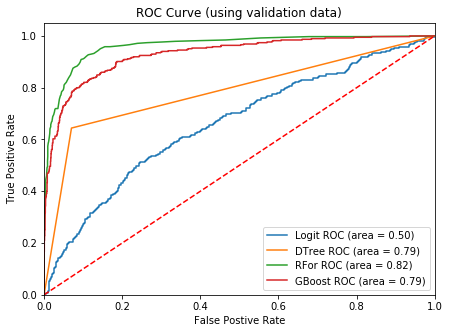

In [24]:
#Plot ROC Curve
plt.figure(figsize = (7, 5))
for m in models:
    model = m['model']
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
    auc = metrics.roc_auc_score(y_test,model.predict(X_test))
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Postive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (using validation data)')
plt.legend(loc="lower right")
plt.show()

In [25]:
# Only keep GBoost and Random Forest as challengers
del_models = ['Logit', 'DTree']        
models = [model_dict for model_dict in models if model_dict['label'] not in del_models]

In [26]:
# Create a XGBoost model
xgb = XGBClassifier(max_depth=4,
                        subsample=0.9,
                        objective='binary:logistic',
                        n_estimators=100,
                        learning_rate = 0.1, random_state=123)
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb.fit(X_train, y_train.values.ravel(), early_stopping_rounds=10,
          eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.130729	validation_0-logloss:0.63298	validation_1-error:0.136248	validation_1-logloss:0.63355
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-error:0.130228	validation_0-logloss:0.583501	validation_1-error:0.133198	validation_1-logloss:0.584555
[2]	validation_0-error:0.129477	validation_0-logloss:0.542331	validation_1-error:0.132181	validation_1-logloss:0.543875
[3]	validation_0-error:0.129977	validation_0-logloss:0.507856	validation_1-error:0.134723	validation_1-logloss:0.510459
[4]	validation_0-error:0.112948	validation_0-logloss:0.478549	validation_1-error:0.112862	validation_1-logloss:0.482106
[5]	validation_0-error:0.111695	validation_0-logloss:0.453207	validation_1-error:0.110829	validation_1-logloss:0.457104
[6]	validation_0-error:0.109692	validation_0-logloss:0.431617	validation_1-error:0.12303	validation_1-logloss:0.43745

C:\Users\canyzn\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[18]	validation_0-error:0.10268	validation_0-logloss:0.301136	validation_1-error:0.114896	validation_1-logloss:0.317351
[19]	validation_0-error:0.102429	validation_0-logloss:0.294944	validation_1-error:0.115404	validation_1-logloss:0.312303
[20]	validation_0-error:0.102429	validation_0-logloss:0.289658	validation_1-error:0.115913	validation_1-logloss:0.307643
[21]	validation_0-error:0.10293	validation_0-logloss:0.285082	validation_1-error:0.114896	validation_1-logloss:0.304836
[22]	validation_0-error:0.10268	validation_0-logloss:0.281139	validation_1-error:0.115404	validation_1-logloss:0.301562
[23]	validation_0-error:0.101427	validation_0-logloss:0.276814	validation_1-error:0.113371	validation_1-logloss:0.297478
[24]	validation_0-error:0.100175	validation_0-logloss:0.272947	validation_1-error:0.114387	validation_1-logloss:0.29444
[25]	validation_0-error:0.099174	validation_0-logloss:0.269315	validation_1-error:0.111337	validation_1-logloss:0.291786
[26]	validation_0-error:0.098422	val

[86]	validation_0-error:0.066617	validation_0-logloss:0.176644	validation_1-error:0.095069	validation_1-logloss:0.235083
[87]	validation_0-error:0.066116	validation_0-logloss:0.175822	validation_1-error:0.095069	validation_1-logloss:0.234349
[88]	validation_0-error:0.065364	validation_0-logloss:0.174961	validation_1-error:0.095577	validation_1-logloss:0.233751
[89]	validation_0-error:0.065114	validation_0-logloss:0.17356	validation_1-error:0.096085	validation_1-logloss:0.233319
[90]	validation_0-error:0.064363	validation_0-logloss:0.172882	validation_1-error:0.095577	validation_1-logloss:0.232657
[91]	validation_0-error:0.064613	validation_0-logloss:0.17251	validation_1-error:0.096085	validation_1-logloss:0.232258
[92]	validation_0-error:0.064112	validation_0-logloss:0.171303	validation_1-error:0.095577	validation_1-logloss:0.231964
[93]	validation_0-error:0.063611	validation_0-logloss:0.170302	validation_1-error:0.095069	validation_1-logloss:0.231543
[94]	validation_0-error:0.063361	v

XGBClassifier(max_depth=4, random_state=123, subsample=0.9)

In [27]:
dt_misclassification = 1 - metrics.accuracy_score(y_test, xgb.predict(X_test))
print('Misclassification Rates\n', 'XGBoost :', dt_misclassification) #0.09303507880020334

Misclassification Rates
 XGBoost : 0.09303507880020334


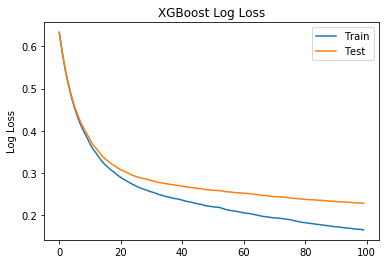

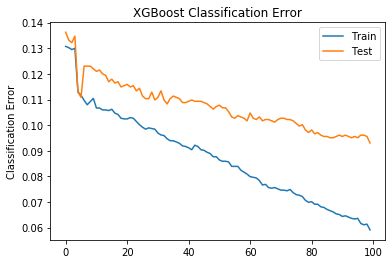

In [28]:
# retrieve performance metrics
results = xgb.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

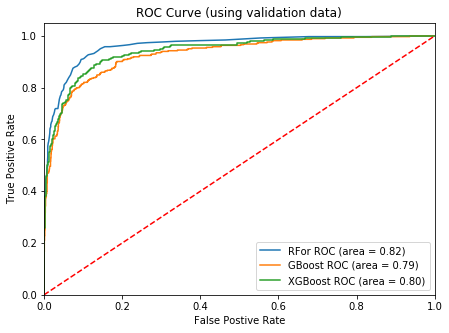

In [29]:
#Compare Gboost, RF and XGBoost
models.append({'label': 'XGBoost','model': xgb})
plt.figure(figsize = (7, 5))
for m in models:
    model = m['model']
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
    auc = metrics.roc_auc_score(y_test,model.predict(X_test))
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Postive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (using validation data)')
plt.legend(loc="lower right")
plt.show() #RandomForest is the best model with AUC of 0.82, followed by XGB of 0.80 and GB of 0.79

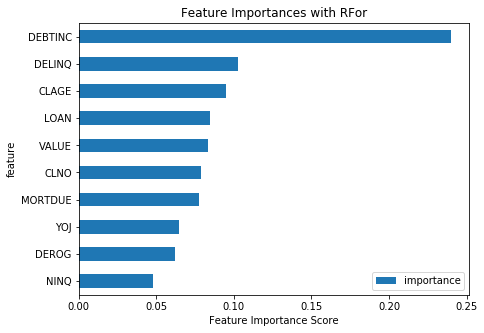

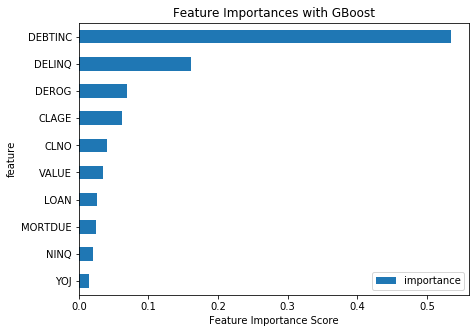

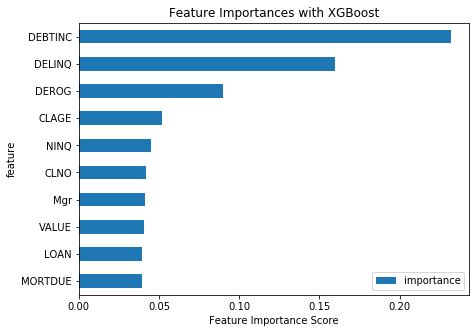

In [30]:
#Check feature importance
for m in models:
    model = m['model']
    feat_imp = pd.DataFrame({'importance':model.feature_importances_})
    feat_imp['feature'] = X_train.columns
    feat_imp.sort_values(by='importance', ascending=False, inplace=True)
    feat_imp = feat_imp.iloc[:10]

    feat_imp.sort_values(by='importance', inplace=True)
    feat_imp = feat_imp.set_index('feature', drop=True)
    feat_imp.plot.barh(title='Feature Importances with {}'.format(m['label']), figsize=(7, 5))
    plt.xlabel('Feature Importance Score')
    plt.show()

In [31]:
#Create a Forest model:
RFor=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)
RFor.fit(X_train, y_train.values.ravel())

RandomForestClassifier(random_state=123)

# USING SASCTL TO IMPORT PYTHON MODELS

In [32]:
#User and password
user = 'gatedemo190'
import getpass
pwd = getpass.getpass()

········


In [33]:
# !pip install sasctl==1.5.8

In [36]:
import sasctl
from sasctl import pzmm as pzmm
sasctl.__version__

'1.5.9'

In [37]:
help(sasctl)

Help on package sasctl:

NAME
    sasctl

DESCRIPTION
    # encoding: utf-8
    #
    # Copyright © 2019, SAS Institute Inc., Cary, NC, USA.  All Rights Reserved.
    # SPDX-License-Identifier: Apache-2.0

PACKAGE CONTENTS
    __main__
    _services (package)
    core
    exceptions
    pzmm (package)
    services
    tasks
    utils (package)

DATA
    __copyright__ = 'Copyright © 2019, SAS Institute Inc., Cary, NC, USA. ...
    __license__ = 'Apache 2.0'

VERSION
    1.5.9

AUTHOR
    SAS

CREDITS
    ['Yi Jian Ching, Lucas De Paula, James Kochuba, Peter Tobac, Chris Toth, Jon Walker']

FILE
    c:\users\canyzn\appdata\local\continuum\anaconda3\lib\site-packages\sasctl\__init__.py




In [38]:
# Import packages for registering and publishing models in sasctl
from sasctl import Session
from sasctl.tasks import register_model, publish_model, update_model_performance
from sasctl.services import model_repository as mr
from sasctl.services import model_management as mm

In [39]:
# Establish a session with SAS Viya
sess=Session('cashost', user, pwd) #should use certificate instead

In [38]:
# Register the model XGB in Model Manager

project = 'HMEQ_OS&MM'

register_model(RFor, 
             'RandomForest_Py_sasctl',
               input=X_train,                 # Use X to determine model inputs
               project='HMEQ_OS&MM',      # Register in an existing MM project
               force=True)   

register_model(xgb, 
             'XGBoost_Py_sasctl',
               input=X_train,                 # Use X to determine model inputs
               project='HMEQ_OS&MM',      # Register in an existing MM project
               force=True)   

C:\Users\canyzn\AppData\Local\Continuum\anaconda3\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
Could not parse requirement: -umpy
Could not parse requirement: -cipy
C:\Users\canyzn\AppData\Local\Continuum\anaconda3\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
Could not parse requirement: -umpy
Could not parse requirement: -cipy


<class 'sasctl.core.RestObj'>(headers={'Server': 'nginx/1.17.8', 'Date': 'Wed, 09 Jun 2021 18:00:19 GMT', 'Content-Type': 'application/vnd.sas.models.model+json;charset=UTF-8', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'Content-Security-Policy': "default-src 'self'; script-src 'self' 'unsafe-inline' 'unsafe-eval'; img-src 'self' *.sas.com blob: data:; style-src 'self' 'unsafe-inline'; child-src 'self' blob: data: mailto:;", 'Last-Modified': 'Wed, 09 Jun 2021 18:00:19 GMT', 'ETag': 'W/"17985ba2d47"', 'X-Content-Type-Options': 'nosniff', 'X-XSS-Protection': '1; mode=block', 'Cache-Control': 'no-cache, no-store, max-age=0, must-revalidate', 'Pragma': 'no-cache', 'Expires': '0', 'Strict-Transport-Security': 'max-age=15724800; includeSubDomains', 'X-Frame-Options': 'SAMEORIGIN'}, data={'creationTimeStamp': '2021-06-09T18:00:18.185Z', 'modifiedTimeStamp': '2021-06-09T18:00:18.185Z', 'createdBy': 'gatedemo190', 'modifiedBy': 'gatedemo190', 'links': [{'method': 'GET', 'rel': 

# USING PZMM FOR OTHER FEATURES

# Create model pipelines

In [40]:
#Random Forest Pipeline
class_inputs = list(df.select_dtypes('object').columns)
numerical_inputs = list(df.select_dtypes(include=['int64', 'float32']).columns)

# Preprocessing interval variables
numeric_transformer = Pipeline(steps=[
    
    ('numerical_imputer', SimpleImputer(strategy='median'))
])

# Preprocessing categorical variables
categorical_transformer = Pipeline(steps=[
    
    ('categorical_imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
    
])

# Create preprocessing step
preprocessor = ColumnTransformer(transformers=[
    
    ('numericals', numeric_transformer, numerical_inputs),
    ('categoricals', categorical_transformer, class_inputs)

])

rfor_pipeline = Pipeline(steps=[
    
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=123))

])

In [41]:
#XGBoost Pipeline
class_inputs = list(df.select_dtypes('object').columns)
numerical_inputs = list(df.select_dtypes(include=['int64', 'float32']).columns)

# Preprocessing interval variables
numeric_transformer = Pipeline(steps=[
    
    ('numerical_imputer', SimpleImputer(strategy='median'))
])

# Preprocessing categorical variables
categorical_transformer = Pipeline(steps=[
    
    ('categorical_imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
    
])

# Create preprocessing step
preprocessor = ColumnTransformer(transformers=[
    
    ('numericals', numeric_transformer, numerical_inputs),
    ('categoricals', categorical_transformer, class_inputs)

])

xgb_pipeline = Pipeline(steps=[
    
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=123))

])

In [42]:
#Test pipeline in production: Create training data
Prod_X_train, Prod_X_test, Prod_y_train, Prod_y_test = model_selection.train_test_split(df[df.columns.difference(target)], 
                                                                    df[target], 
                                                                    test_size=0.33, random_state=27513)

In [43]:
Prod_X_train.columns

Index(['CLAGE', 'CLNO', 'DEBTINC', 'DELINQ', 'DEROG', 'JOB', 'LOAN', 'MORTDUE',
       'NINQ', 'REASON', 'VALUE', 'YOJ'],
      dtype='object')

In [44]:
rfor_pipeline.fit(Prod_X_train, Prod_y_train)
Prod_y_predict=rfor_pipeline.predict_proba(Prod_X_test)
#check score for RF
rfor_pipeline.score(Prod_X_test, Prod_y_test) #0.9166243009659379

C:\Users\canyzn\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


0.9166243009659379

In [45]:
xgb_pipeline.fit(Prod_X_train, Prod_y_train)
Prod_y_predict=xgb_pipeline.predict_proba(Prod_X_test)
#check score for XGB
xgb_pipeline.score(Prod_X_test, Prod_y_test) #0.8993390950686324

C:\Users\canyzn\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.8993390950686324

In [51]:
help(register_model)

Help on function register_model in module sasctl.tasks:

register_model(model, name, project, repository=None, input=None, version=None, files=None, force=False, record_packages=True)
    Register a model in the model repository.
    
    Parameters
    ----------
    model : swat.CASTable or sklearn.BaseEstimator
        The model to register.  If an instance of ``swat.CASTable`` the table
        is assumed to hold an ASTORE, which will be downloaded and used to
        construct the model to register.  If a scikit-learn estimator, the
        model will be pickled and uploaded to the registry and score code will
        be generated for publishing the model to MAS.
    name : str
        Designated name for the model in the repository.
    project : str or dict
        The name or id of the project, or a dictionary representation of
        the project.
    repository : str or dict, optional
        The name or id of the repository, or a dictionary representation of
        the repo

# Apply PZMM to calculate FitStat, metadata, model properties, etc.

In [54]:
trainedModel_RF=rfor_pipeline
trainedModel_XGB=xgb_pipeline

In [55]:
#Define output variable: Random Forest
yCategory_RF = trainedModel_RF.predict(df[df.columns.difference(target)])
yProb_RF=1-trainedModel_RF.predict_proba(df[df.columns.difference(target)])
outputVar_RF = pd.DataFrame(columns=['EM_EVENTPROBABILITY', 'EM_CLASSIFICATION'])
outputVar_RF['EM_CLASSIFICATION'] = yCategory_RF.astype('str')
outputVar_RF['EM_EVENTPROBABILITY'] = yProb_RF

In [56]:
#Define output variable: XGB
yCategory_XGB = trainedModel_XGB.predict(df[df.columns.difference(target)])
yProb_XGB=1-trainedModel_XGB.predict_proba(df[df.columns.difference(target)])
outputVar_XGB = pd.DataFrame(columns=['EM_EVENTPROBABILITY', 'EM_CLASSIFICATION'])
outputVar_XGB['EM_CLASSIFICATION'] = yCategory_XGB.astype('str')
outputVar_XGB['EM_EVENTPROBABILITY'] = yProb_XGB

In [57]:
targetName = 'BAD'
targetValue = 1

In [58]:
help(pzmm.PickleModel.pickleTrainedModel)

Help on function pickleTrainedModel in module sasctl.pzmm.pickleModel:

pickleTrainedModel(self, trainedModel, modelPrefix, pPath=WindowsPath('C:/Users/canyzn'), isH2OModel=False)
    Write trained model to a binary pickle file. 
    
    Parameters
    ---------------
    trainedModel : model or string or Path
        For non-H2O models, this argument contains the model variable. Otherwise,
        this should be the file path of the MOJO file.
    modelPrefix : string
        Variable name for the model to be displayed in SAS Open Model Manager 
        (i.e. hmeqClassTree + [Score.py || .pickle]).
    pPath : string, optional
        File location for the output pickle file. Default is the current
        working directory.
    isH2OModel : boolean, optional
        Sets whether the model file is an H2O.ai MOJO file. If set as True, 
        the MOJO file will be gzipped before uploading to SAS Model Manager.
        The default value is False.
                    
            Yield

In [59]:
modelPrefix_RF='hmeqForest_pzmm'
PickleModel=pzmm.PickleModel()
PickleModel.pickleTrainedModel(trainedModel_RF,modelPrefix_RF,zipFolder_RF)
modelPrefix_XGB='hmeqXGB_pzmm'
PickleModel.pickleTrainedModel(trainedModel_XGB, modelPrefix_XGB,zipFolder_XGB)

In [60]:
#Forest
from sasctl import pzmm as pzmm
JSONFiles = pzmm.JSONFiles()
JSONFiles.writeVarJSON(df[df.columns.difference(target)], isInput=True, jPath=zipFolder_RF)

JSONFiles.writeVarJSON(outputVar_RF, isInput=False, jPath=zipFolder_RF)

modelName = 'Home Equity Loan Classification Forest'
JSONFiles.writeModelPropertiesJSON(modelName=modelName,
                                        modelDesc='',
                                        targetVariable=targetName,
                                        modelType='Random Forest',
                                        modelPredictors=(inputs),
                                        targetEvent=yCategory_RF[1].astype('str'),
                                        numTargetCategories=len(yCategory_RF),
                                        eventProbVar='EM_EVENTPROBABILITY',
                                        jPath=zipFolder_RF)

JSONFiles.writeFileMetadataJSON(modelPrefix_RF, jPath=zipFolder_RF)

In [61]:
#XGB
JSONFiles = pzmm.JSONFiles()
JSONFiles.writeVarJSON(df[df.columns.difference(target)], isInput=True, jPath=zipFolder_XGB)

JSONFiles.writeVarJSON(outputVar_XGB, isInput=False, jPath=zipFolder_XGB)

modelName = 'Home Equity Loan Classification XGB'
JSONFiles.writeModelPropertiesJSON(modelName=modelName,
                                        modelDesc='',
                                        targetVariable=targetName,
                                        modelType='Gradient Boosting',
                                        modelPredictors=(inputs),
                                        targetEvent=yCategory_XGB[1].astype('str'),
                                        numTargetCategories=len(yCategory_XGB),
                                        eventProbVar='EM_EVENTPROBABILITY',
                                        jPath=zipFolder_XGB)

JSONFiles.writeFileMetadataJSON(modelPrefix_XGB, jPath=zipFolder_XGB)

In [62]:
from pathlib import Path

In [63]:
#Create a swat connection for pzmm
# sess=Session('viya4demo01.canadacentral.cloudapp.azure.com', user, pwd)
conn=sess.as_swat()

In [64]:
#Generate Metrics: RFor
yTrainActual_RF = Prod_y_train
yTrainPredict_RF = trainedModel_RF.predict_proba(Prod_X_train)
# yTrainPredict_XGB=y_TrainPredict_XGB.tolist()
traindf=pd.concat([yTrainActual_RF.reset_index(drop=True),pd.Series(data=yTrainPredict_RF[:,1])],axis=1)

yTestActual_RF = Prod_y_test
yTestPredict_RF = trainedModel_RF.predict_proba(Prod_X_test)
# yTestPredict_XGB=y_TestPredict_XGB.tolist()
testdf=pd.concat([yTestActual_RF.reset_index(drop=True),pd.Series(data=yTestPredict_RF[:,1])],axis=1)

# data=[(None,None),(yTrainActual_RF, yTrainPredict_RF),(yTestActual_RF, yTestPredict_RF)]

JSONFiles = pzmm.JSONFiles()
jsonPath = zipFolder_RF
JSONFiles.calculateFitStat(trainData=traindf,testData=testdf,jPath=jsonPath)
JSONFiles.generateROCLiftStat(targetName,1,conn,trainData=traindf,testData=testdf, jPath=jsonPath)

# JSONFiles.generateROCStat(data, targetName, jsonPath)
# JSONFiles.generateLiftStat(data, targetName, targetValue, jsonPath)

In [65]:
yTrainActual_RF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3993 entries, 4318 to 5788
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   BAD     3993 non-null   category
dtypes: category(1)
memory usage: 35.2 KB


In [66]:
#Generate Metrics: XGB
yTrainActual_XGB = Prod_y_train
yTrainPredict_XGB = trainedModel_XGB.predict_proba(Prod_X_train)
# yTrainPredict_XGB=y_TrainPredict_XGB.tolist()
traindf=pd.concat([yTrainActual_XGB.reset_index(drop=True),pd.Series(data=yTrainPredict_XGB[:,1])],axis=1)

yTestActual_XGB = Prod_y_test
yTestPredict_XGB = trainedModel_XGB.predict_proba(Prod_X_test)
# yTestPredict_XGB=y_TestPredict_XGB.tolist()
testdf=pd.concat([yTestActual_XGB.reset_index(drop=True),pd.Series(data=yTestPredict_XGB[:,1])],axis=1)

# data=[(None,None),(yTrainActual_XGB, yTrainPredict_XGB),(yTestActual_XGB, yTestPredict_XGB)]

JSONFiles = pzmm.JSONFiles()
jsonPath = zipFolder_XGB
JSONFiles.calculateFitStat(trainData=traindf,testData=testdf,jPath=jsonPath)
JSONFiles.generateROCLiftStat(targetName,1,conn,trainData=traindf,testData=testdf, jPath=jsonPath)


# JSONFiles.generateROCStat(data, targetName, jsonPath)
# JSONFiles.generateLiftStat(data, targetName, targetValue, jsonPath)

# ZIP models and dependencies

In [67]:
help(pzmm.ZipModel.zipFiles)

Help on function zipFiles in module sasctl.pzmm.zipModel:

zipFiles(fileDir, modelPrefix)
    Combines all JSON files with the model pickle file and associated score code file
    into a single archive ZIP file.
    
    Parameters
    ---------------
    fileDir : string
        Location of *.json, *.pickle, and *Score.py files.
    modelPrefix : string
        Variable name for the model to be displayed in SAS Open Model Manager 
        (i.e. hmeqClassTree + [Score.py || .pickle]).
        
    Yields
    ---------------
    '*.zip'
        Archived ZIP file for importing into SAS Open Model Manager. In this form,
        the ZIP file can be imported into SAS Open Model Manager.



In [68]:
#ZipModel
ZipModel=pzmm.ZipModel()
ZipModel.zipFiles(fileDir=zipFolder_RF, modelPrefix=modelPrefix_RF)
ZipModel.zipFiles(fileDir=zipFolder_XGB, modelPrefix=modelPrefix_XGB)

# Push zipped models into SAS Model Manager

In [69]:
ModelImport = pzmm.ImportModel()

In [70]:
help(pzmm.ImportModel)

Help on class ImportModel in module sasctl.pzmm.importModel:

class ImportModel(builtins.object)
 |  Class methods defined here:
 |  
 |  pzmmImportModel(zPath, modelPrefix, project, inputDF, targetDF, predictmethod, metrics=['EM_EVENTPROBABILITY', 'EM_CLASSIFICATION'], modelFileName=None, pyPath=None, threshPrediction=None, otherVariable=False, isH2OModel=False) from builtins.type
 |      Import model to SAS Model Manager using pzmm submodule.
 |      
 |      Using pzmm, generate Python score code and import the model files into 
 |      SAS Model Manager. This function automatically checks the version of SAS
 |      Viya being used through the sasctl Session object and creates the appropriate
 |      score code and API calls required for the model and its associated content to 
 |      be registered in SAS Model Manager.
 |      
 |      Parameters
 |      ----------
 |      zPath : string or Path
 |          Directory location of the files to be zipped and imported as a model.
 |  

In [73]:
##### Push Forest Model into SAS Model Manager
# zPath = Path(zipFolder_RF) / (modelPrefix_RF +'.zip')
with sess:
    ModelImport.pzmmImportModel(zPath= Path.cwd()/'Model'/'Random_Forest',
                                modelPrefix=modelPrefix_RF+'new',
                                project='HMEQ', 
                                inputDF=df[df.columns.difference(target)],
                                targetDF=df[target],
                                predictmethod= '{}.predict({})',
                                isH2OModel=False)

In [72]:
#Push XGB Model into SAS Model Manager
with sess:
    ModelImport.pzmmImportModel(zPath= zipFolder_XGB,
                                modelPrefix=modelPrefix_XGB,
                                project='HMEQ', 
                                inputDF=df[df.columns.difference(target)],
                                targetDF=df[target],
                                predictmethod= '{}.predict({})',
                                isH2OModel=False)

HTTPError: HTTP Error 409: {"errorCode":21201,"message":"The name \"hmeqXGB_pzmm\" is already in use in the selected folder. Enter a unique name.","details":["traceId: 641a91736afe3771","path: /modelRepository/models"],"links":[],"version":2,"httpStatusCode":409}

# USING PMML TO WRAP A MODEL TO BE IMPORTED TO SAS MM

In [109]:
#Import packages
!pip install --upgrade git+https://github.com/jpmml/sklearn2pmml.git
# from sklearn2pmml import sklearn2pmml
from sklearn2pmml.pipeline import PMMLPipeline

  Cloning https://github.com/jpmml/sklearn2pmml.git to c:\users\canyzn\appdata\local\temp\pip-req-build-qyswrfhs
  Stored in directory: C:\Users\canyzn\AppData\Local\Temp\pip-ephem-wheel-cache-0acemd6l\wheels\a5\16\28\39a02d646759c3c329275b8553d0a4c8635c9ff7a5ee5c73ba
Successfully built sklearn2pmml
  Found existing installation: sklearn2pmml 0.52.0
    Uninstalling sklearn2pmml-0.52.0:
      Successfully uninstalled sklearn2pmml-0.52.0


  Running command git clone -q https://github.com/jpmml/sklearn2pmml.git 'C:\Users\canyzn\AppData\Local\Temp\pip-req-build-qyswrfhs'


In [110]:
#Random Forest Pipeline - PMML
class_inputs = list(df.select_dtypes('object').columns)
numerical_inputs = list(df.select_dtypes(include=['int64', 'float32']).columns)

# Preprocessing interval variables
numeric_transformer = Pipeline(steps=[
    
    ('numerical_imputer', SimpleImputer(strategy='median'))
])

# Preprocessing categorical variables
categorical_transformer = Pipeline(steps=[
    
    ('categorical_imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
    
])

# Create preprocessing step
preprocessor = ColumnTransformer(transformers=[
    
    ('numericals', numeric_transformer, numerical_inputs),
    ('categoricals', categorical_transformer, class_inputs)

])

rfor_pipeline = PMMLPipeline(steps=[
    
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=123))

])

In [111]:
#Test pipeline in production: Create training data
Prod_X_train, Prod_X_test, Prod_y_train, Prod_y_test = model_selection.train_test_split(df[df.columns.difference(target)], 
                                                                    df[target], 
                                                                    test_size=0.33, random_state=27513)

In [112]:
# Fit the trained RFor pipeline
rfor_pipeline.fit(Prod_X_train,Prod_y_train)
y_pred_pmml=rfor_pipeline.predict(Prod_X_test)
print("Accuracy:",metrics.accuracy_score(Prod_y_test, y_pred_pmml))

C:\Users\canyzn\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Accuracy: 0.9166243009659379


In [114]:
from sklearn2pmml import sklearn2pmml

In [115]:
#Writing the PMML pipeline for Forest
sklearn2pmml(rfor_pipeline, 'C:/Users/canyzn/Model/Random_Forest/hmeqForest_py_PMML.pmml', with_repr = True)
print('PMML  down!')

PMML  down!


In [119]:
#XGBoost Pipeline
class_inputs = list(df.select_dtypes('object').columns)
numerical_inputs = list(df.select_dtypes(include=['int64', 'float32']).columns)

# Preprocessing interval variables
numeric_transformer = Pipeline(steps=[
    
    ('numerical_imputer', SimpleImputer(strategy='median'))
])

# Preprocessing categorical variables
categorical_transformer = Pipeline(steps=[
    
    ('categorical_imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
    
])

# Create preprocessing step
preprocessor = ColumnTransformer(transformers=[
    
    ('numericals', numeric_transformer, numerical_inputs),
    ('categoricals', categorical_transformer, class_inputs)

])

xgb_pipeline = PMMLPipeline(steps=[
    
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=123))

])


In [120]:
# Fit the trained RFor pipeline
xgb_pipeline.fit(Prod_X_train,Prod_y_train)
y_pred_pmml=xgb_pipeline.predict(Prod_X_test)
print("Accuracy:",metrics.accuracy_score(Prod_y_test, y_pred_pmml))

C:\Users\canyzn\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy: 0.8993390950686324


In [122]:
#Writing the PMML pipeline for Forest
sklearn2pmml(xgb_pipeline, 'C:/Users/canyzn/Model/XGBoost/hmeqXGB_py_PMML.pmml', with_repr = True)
print('PMML  down!')

PMML  down!
